In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from tensorflow.keras import layers
import time
from datetime import timedelta

from IPython import display

TensorFlow 2.x selected.


In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

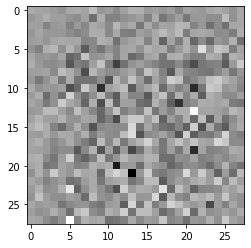

In [8]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [9]:
# Generator Summary
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision.numpy())

[[-0.00100052]]


In [12]:
# Discriminator Summary
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [0]:
def train(dataset, epochs):
  if not os.path.exists('./generator'):
    os.mkdir('./generator')
  if not os.path.exists('./discriminator'):
    os.mkdir('./discriminator')
  generate_and_save_images(generator, 0, seed, save_img=True)
  
  gen_losses = []
  disc_losses = []
  start_training = time.perf_counter()

  for epoch in range(1, epochs + 1):
    gen_loss = tf.keras.metrics.Mean()
    disc_loss = tf.keras.metrics.Mean()

    start = time.time()
    for image_batch in dataset:
      gl, dl = train_step(image_batch)
      gen_loss(gl)
      disc_loss(dl)
    elapsed = time.time() - start

    gen_losses.append(gen_loss.result())
    disc_losses.append(disc_loss.result())

    display.clear_output(wait=True)
    print (f'ETA: {timedelta(seconds=int(elapsed * (epochs - epoch)))}\tEpoch: {epoch}/{epochs}\tGenerator Loss: {gen_losses[-1]:.4f}\tDiscriminator Loss: {disc_losses[-1]:.4f}')
    generate_and_save_images(generator, epoch, seed, epoch % 5 == 0)

    if epoch == epochs:
      generator.save_weights(f'./generator/generator-{epoch:04d}.h5')
      discriminator.save_weights(f'./discriminator/discriminator-{epoch:04d}.h5')

  training_time = time.perf_counter() - start_training

  return gen_losses, disc_losses, training_time

In [0]:
def generate_and_save_images(model, epoch, test_input, save_img=False, folder='images'):
  if not os.path.exists(folder):
    os.mkdir(folder)
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  if save_img:
    plt.savefig(f'{folder}/{folder}_{epoch:04d}.png')
  plt.show()

ETA: 0:00:00	Epoch: 500/500	Generator Loss: 0.8763	Discriminator Loss: 1.2892


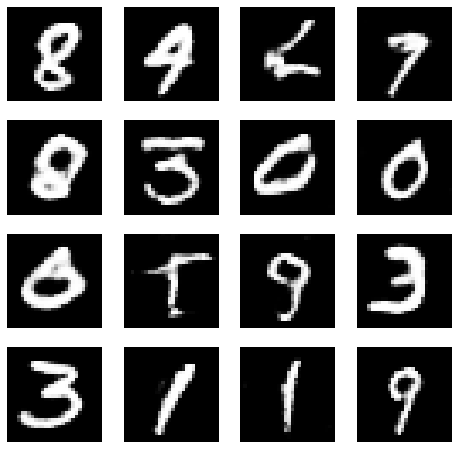

In [22]:
gen_losses, disc_losses, training_time = train(train_dataset, EPOCHS)

In [23]:
print(f'Training Time: {timedelta(seconds=int(training_time))}')

Training Time: 1:49:38


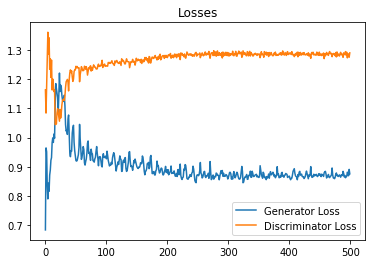

In [24]:
plt.plot(list(range(len(gen_losses))), gen_losses, label='Generator Loss')
plt.plot(list(range(len(disc_losses))), disc_losses, label='Discriminator Loss')
plt.title('Losses')
plt.legend()

plt.savefig('dcgan-losses.png')
plt.show()

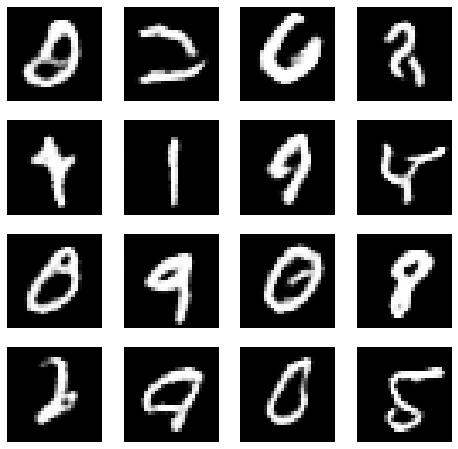

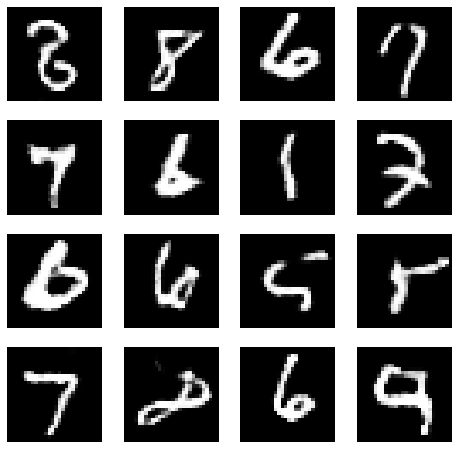

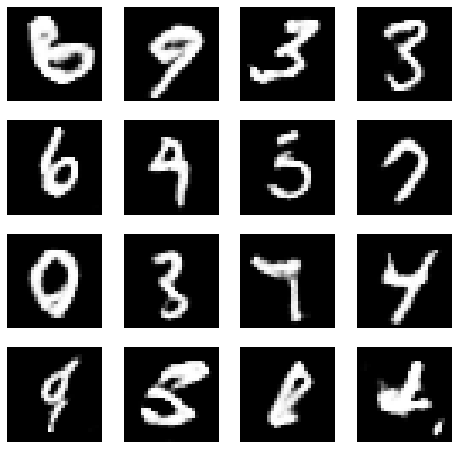

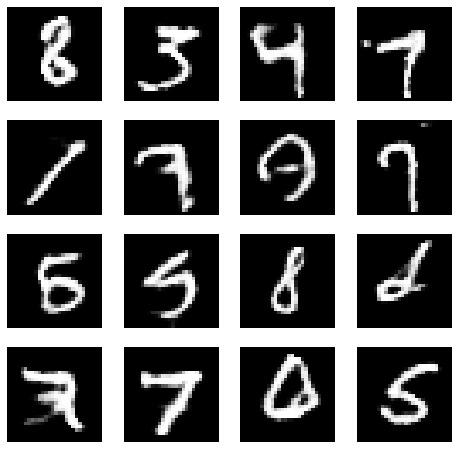

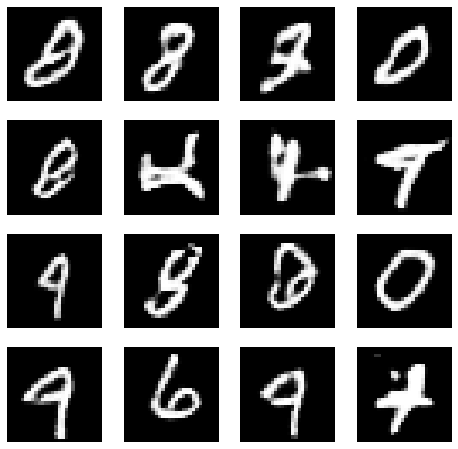

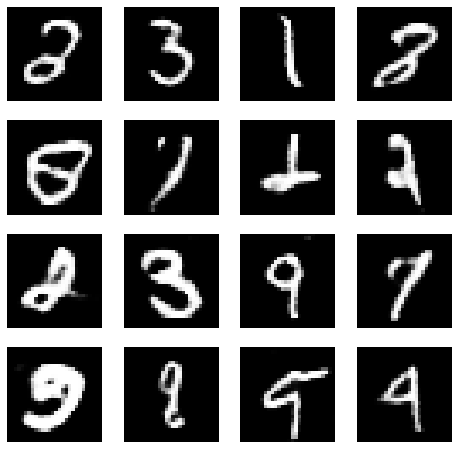

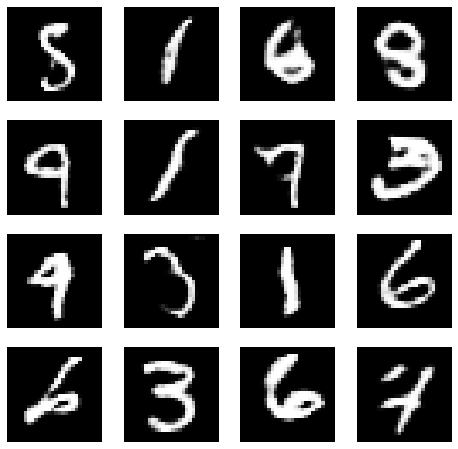

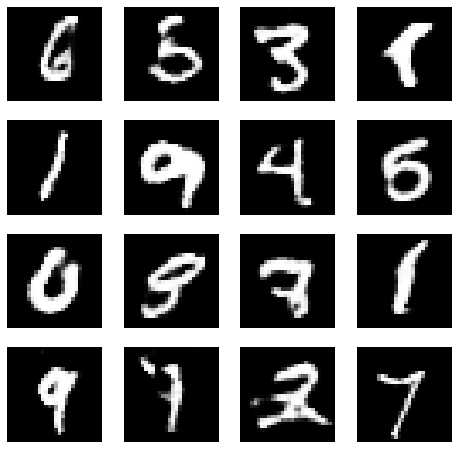

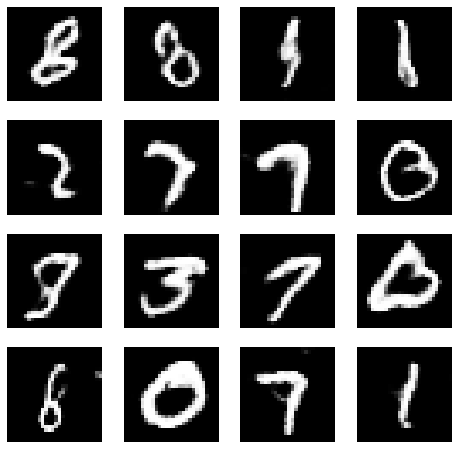

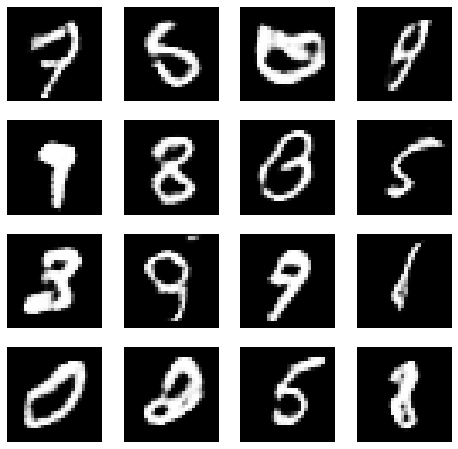

In [29]:
for j in range(10):
  seed = tf.random.normal([num_examples_to_generate, noise_dim])
  generate_and_save_images(generator, j, seed, save_img=True, folder='samples')

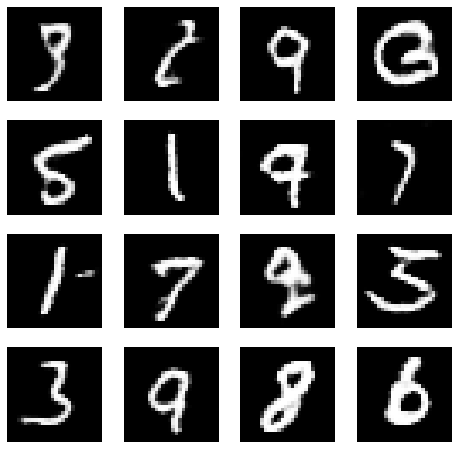

Predictions for above generated imagrs:
 [[3 2 9 3]
 [5 1 9 7]
 [1 7 9 3]
 [3 9 8 6]]


In [40]:
seed = tf.random.normal(shape=[16, 100])
samples = (generator.predict(seed) + 1) / 2

benchmark_model = tf.keras.models.load_model('mnist-benchmark.h5')
predictions = benchmark_model.predict_classes(samples)

fig = plt.figure(figsize=(8, 8))

for i in range(samples.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(samples[i, :, :, 0] * 255, cmap='gray')
    plt.axis('off')

plt.show()
print('Predictions for above generated imagrs:\n', predictions.reshape((4, 4)))